In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                             ConfusionMatrixDisplay, roc_auc_score, 
                             RocCurveDisplay, precision_recall_curve)

# 1. Load Data 
data_path = '../diabetic_data.csv'
df = pd.read_csv(data_path)

# 2. High-Standard Cleaning
df.replace('?', np.nan, inplace=True)
# Dropping columns with too many missing values
df.drop(columns=['weight', 'payer_code', 'medical_specialty', 'encounter_id', 'patient_nbr'], inplace=True)
df.dropna(subset=['diag_1', 'diag_2', 'diag_3', 'race'], inplace=True)

# 3. Target Engineering - Binary Classification
df['readmitted'] = df['readmitted'].replace({'>30': 1, '<30': 1, 'NO': 0})

# 4. Professional Encoding
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col].astype(str))

# 5. Strategic Split
X = df.drop('readmitted', axis=1)
y = df['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"✅ Data Prepped. Training set size: {X_train.shape[0]} rows.")
print(f"Target Distribution:\n{y.value_counts(normalize=True)}")

C:\Users\dkshp\AppData\Local\Temp\ipykernel_8260\3251259919.py:28: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  for col in df.select_dtypes(include=['object']).columns:


✅ Data Prepped. Training set size: 78442 rows.
Target Distribution:
readmitted
0    0.533773
1    0.466227
Name: proportion, dtype: float64


In [6]:
# 1. Initialize the Forest with Advanced Hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=200,           # More trees = more stability
    criterion='entropy',        # Information gain focus
    max_depth=20,               # Deep enough to capture complexity, shallow enough to avoid noise
    min_samples_split=10,       # Prevents the model from creating branches for unique, outlier patients
    class_weight='balanced_subsample', # Professional balancing technique
    random_state=42,
    n_jobs=-1                   # Uses all CPU cores for speed
)

# 2. Fit the Model
print("🌲 Training the Forest (200 trees)...")
rf_model.fit(X_train, y_train)

# 3. Generate Predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("✅ Training Complete.")

🌲 Training the Forest (200 trees)...
✅ Training Complete.


C:\Users\dkshp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


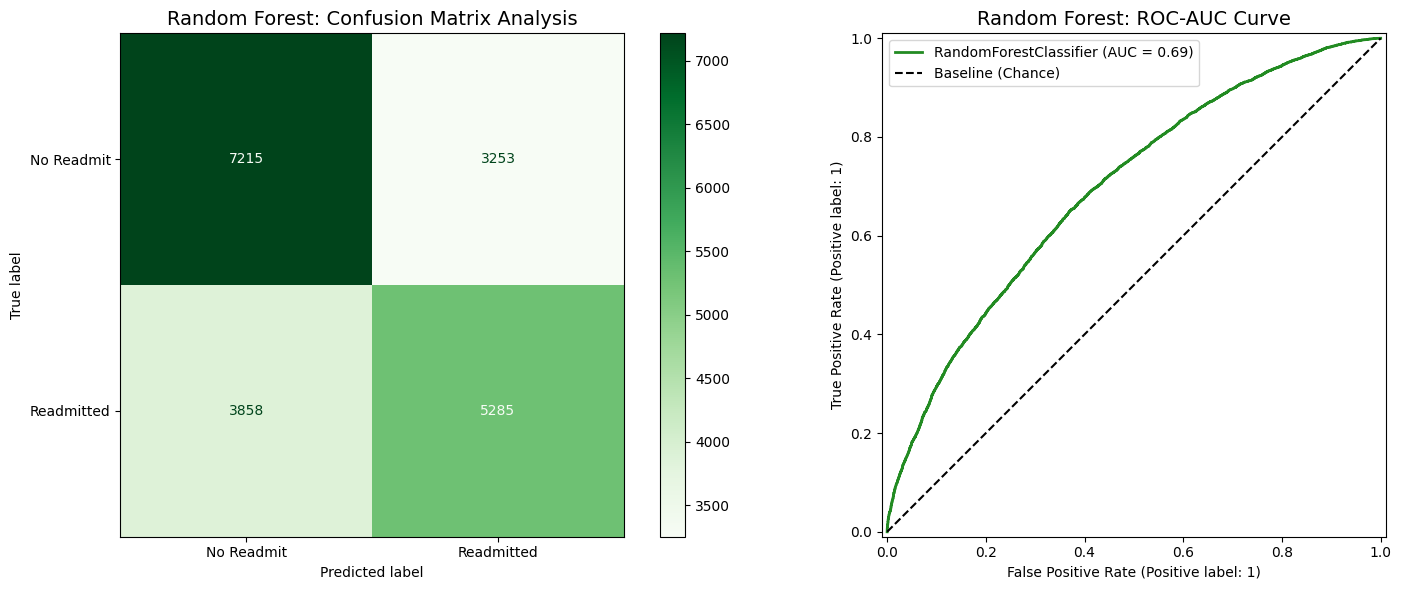

======= FINAL MODEL EVALUATION =======
Accuracy Score: 0.6374
Area Under Curve (AUC): 0.6940

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67     10468
           1       0.62      0.58      0.60      9143

    accuracy                           0.64     19611
   macro avg       0.64      0.63      0.63     19611
weighted avg       0.64      0.64      0.64     19611



In [ ]:
# 1. Setup the visualization area
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 2. Confusion Matrix - Professional View
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_rf, 
    display_labels=['No Readmit', 'Readmitted'],
    cmap='Greens',
    ax=ax1
)
ax1.set_title('Random Forest: Confusion Matrix Analysis', fontsize=14)

# 3. ROC Curve
# This proves the model's ability to separate classes better than random guessing
RocCurveDisplay.from_estimator(
    rf_model, 
    X_test, 
    y_test, 
    ax=ax2,
    color='forestgreen',
    linewidth=2
)
ax2.plot([0, 1], [0, 1], 'k--', label='Baseline (Chance)') 
ax2.set_title('Random Forest: ROC-AUC Curve', fontsize=14)
ax2.legend()

plt.tight_layout()
plt.show()

# 4. Detailed Statistical Report
print("======= FINAL MODEL EVALUATION =======")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Area Under Curve (AUC): {roc_auc_score(y_test, y_prob_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

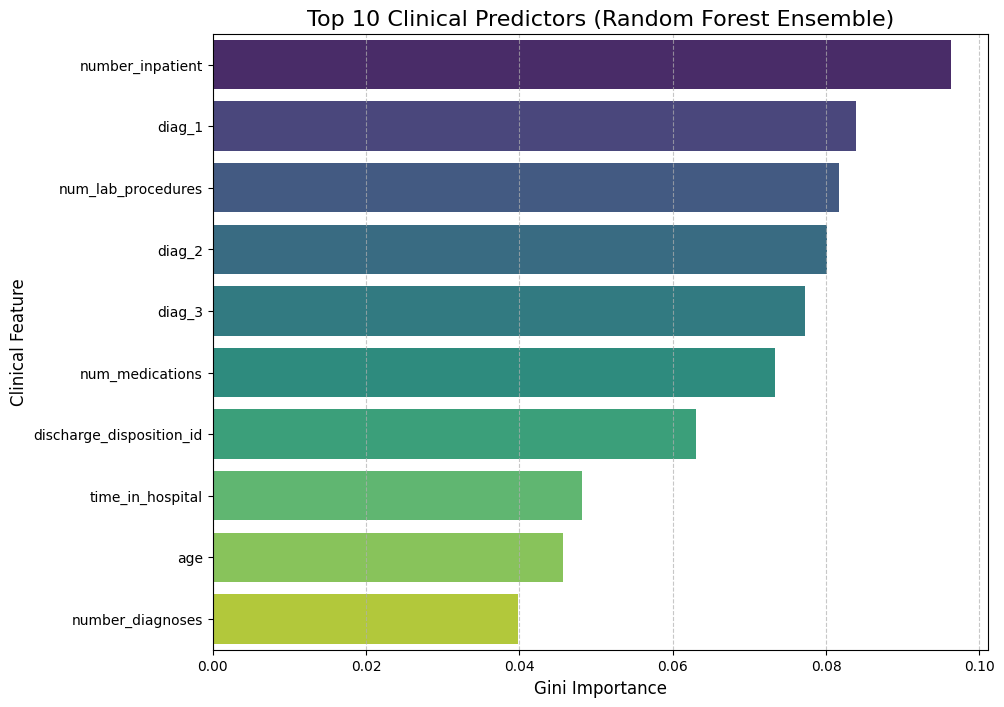

The 'Forest' has spoken. The most critical feature is: number_inpatient


In [ ]:
# Extract and Sort Feature Importance
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# 2. Visualization
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_df, 
    hue='Feature', 
    palette='viridis', 
    legend=False
)
plt.title('Top 10 Clinical Predictors (Random Forest Ensemble)', fontsize=16)
plt.xlabel('Gini Importance', fontsize=12)
plt.ylabel('Clinical Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 3. Insight for the report
top_feature = feature_importance_df.iloc[0]['Feature']
print(f"The 'Forest' has spoken. The most critical feature is: {top_feature}")

In [9]:
import os
from sklearn.metrics import precision_recall_fscore_support

# 1. Extract specific metrics for Class 1 (Readmitted)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_rf, average=None)

current_model_name = "Random Forest"
results_path = '../overall_results.csv'

# 2. Create the result row
new_result = pd.DataFrame({
    'Model': [current_model_name],
    'Accuracy': [accuracy_score(y_test, y_pred_rf)],
    'Recall_C1': [recall[1]], # Your 0.58 score
    'F1_Score': [f1[1]]      # Your 0.60 score
})

# 3. Update the central CSV
if not os.path.isfile(results_path):
    new_result.to_csv(results_path, index=False)
else:
    df_existing = pd.read_csv(results_path)
    # Remove previous entry for this model to avoid duplicates
    df_existing = df_existing[df_existing['Model'] != current_model_name]
    pd.concat([df_existing, new_result], ignore_index=True).to_csv(results_path, index=False)

print(f"✅ Success! '{current_model_name}' metrics have been pushed to the main scoreboard.")

✅ Success! 'Random Forest' metrics have been pushed to the main scoreboard.
